# Building and testing optimal markowitz portfolio on week stock data
* 1 week was taken as base time interval
* investment date: 01.12.2022
* availible risk free investment with 3% return
* 2 types of portfolio: long only and with short positions
* tau - risk parameter, greater value represents more volatile portfolio 
* mean returns and covariation matrix estimates on 20 last intervals
* investment balance in 10 000

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (24, 12)
plt.style.use('fivethirtyeight')

## Data for 7 stoks for 5y, 1wk timeframe

In [2]:
data = pd.read_csv('data_update 5y 1wk.csv', index_col=0, parse_dates=[0])
data.tail()

,AAPL,AMZN,COST,MSFT,NFLX,NVDA,TSLA,risk_free
2022-11-03,138.880005,89.300003,486.290009,214.250000,269.059998,134.210007,215.309998,1.156836
2022-11-10,146.869995,96.629997,513.130005,242.979996,274.970001,157.500000,190.720001,1.157492
2022-11-17,150.720001,94.849998,521.320007,241.679993,295.279999,156.770004,183.169998,1.158148
2022-11-24,151.070007,94.129997,534.489990,247.580002,291.500000,165.190002,183.199997,1.158805
2022-12-01,148.309998,95.500000,503.859985,254.690002,316.950012,171.350006,194.699997,1.159462


In [3]:
data.shape

(262, 8)

In [4]:
size = 20
size

20

In [5]:
data = data.iloc[-size:]
data.shape

(20, 8)

## Annual returns

In [6]:
tickers = list(data.columns)
tickers

['AAPL', 'AMZN', 'COST', 'MSFT', 'NFLX', 'NVDA', 'TSLA', 'risk_free']

[Text(0.5, 1.0, 'Price')]

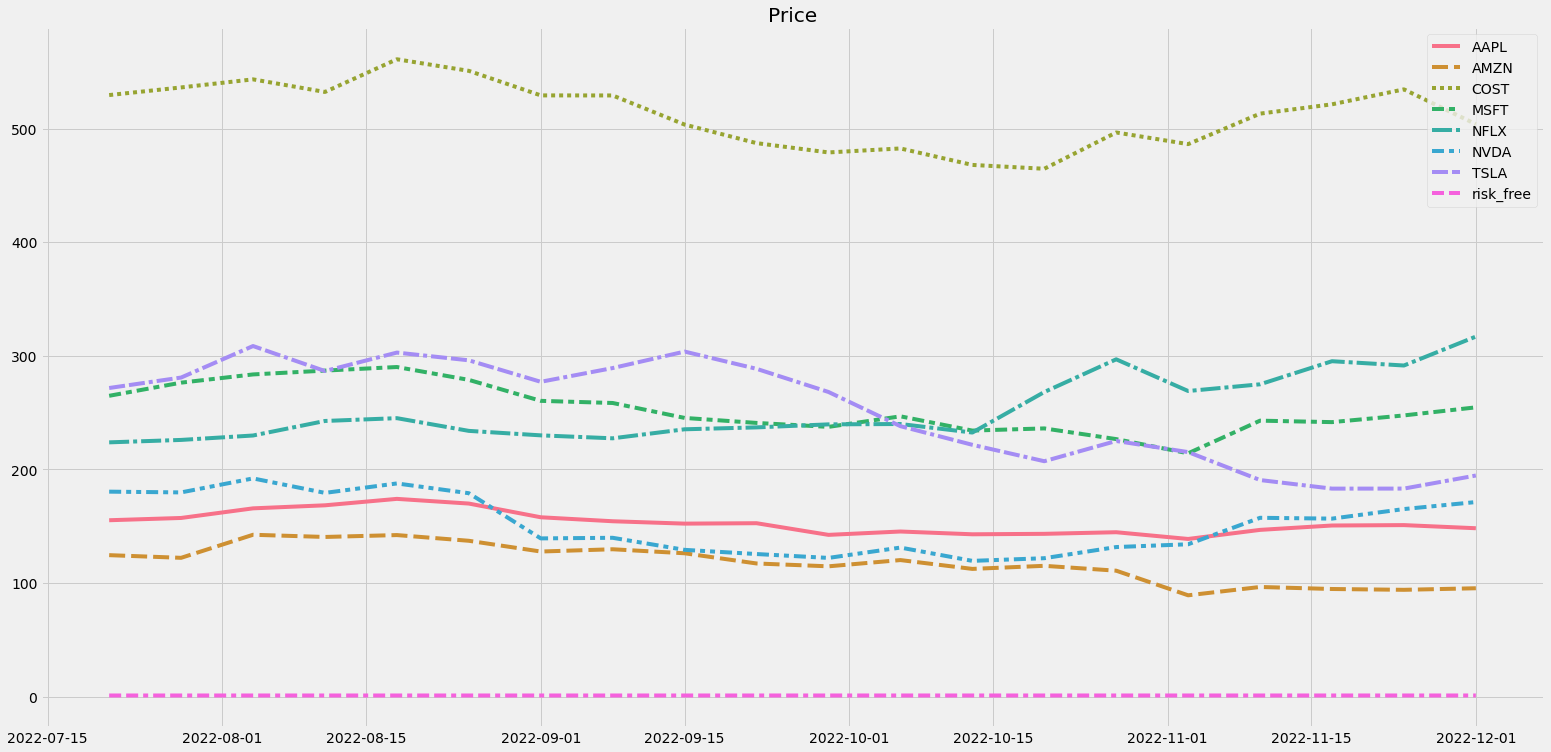

In [7]:
sns.lineplot(data=data).set(title='Price')

[Text(0.5, 1.0, 'Investment return')]

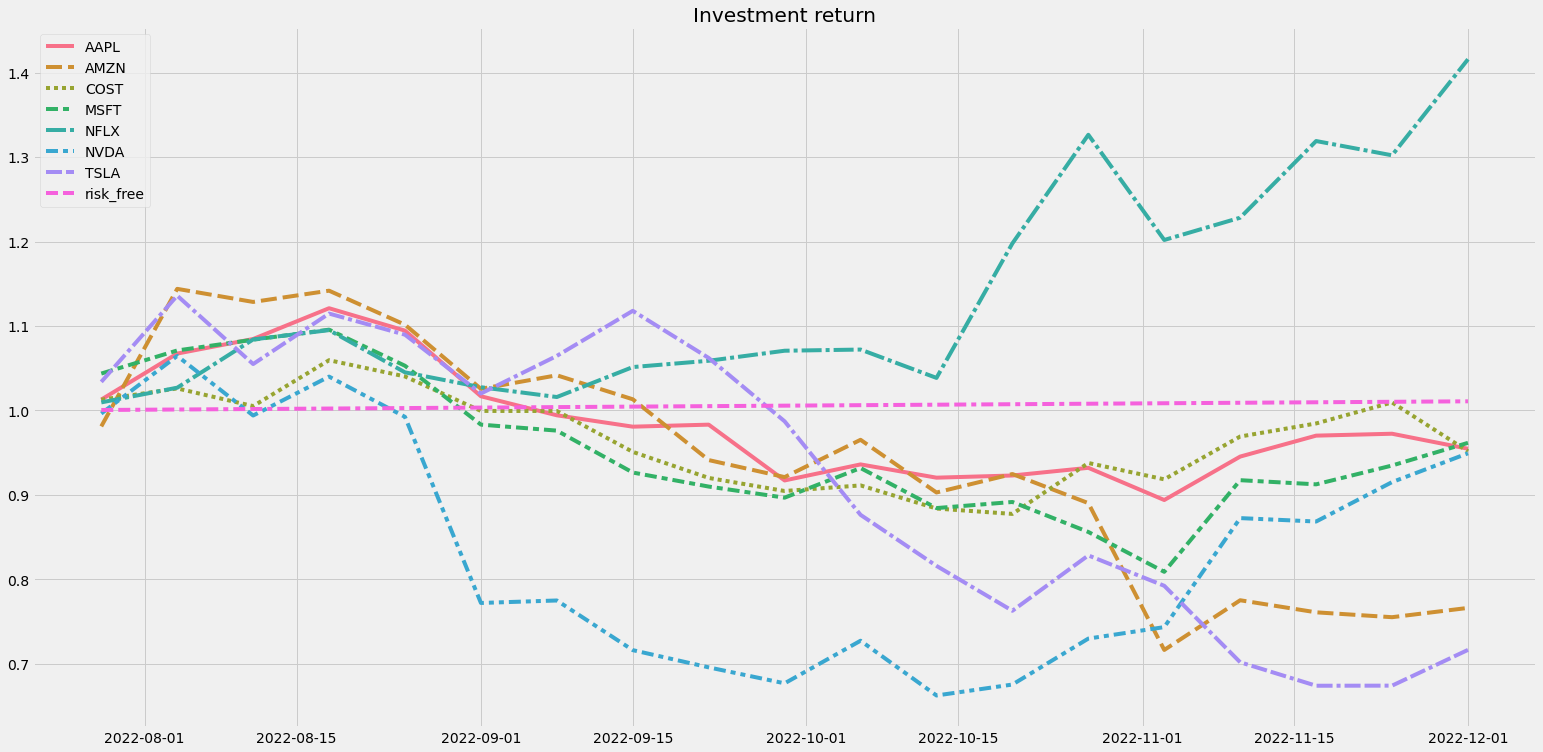

In [8]:
df = data.copy()

df_r = ((df - df.shift()) / df.shift()).dropna()
sns.lineplot(data=(1 + df_r).cumprod()).set(title='Investment return')

In [9]:
df_r.mean().to_frame('return').sort_values('return', ascending=False)

,return
NFLX,0.019954
NVDA,0.000705
risk_free,0.000567
MSFT,-0.001026
AAPL,-0.001853
COST,-0.002017
AMZN,-0.011432
TSLA,-0.015250


[Text(0.5, 1.0, 'Week return covariance matrix')]

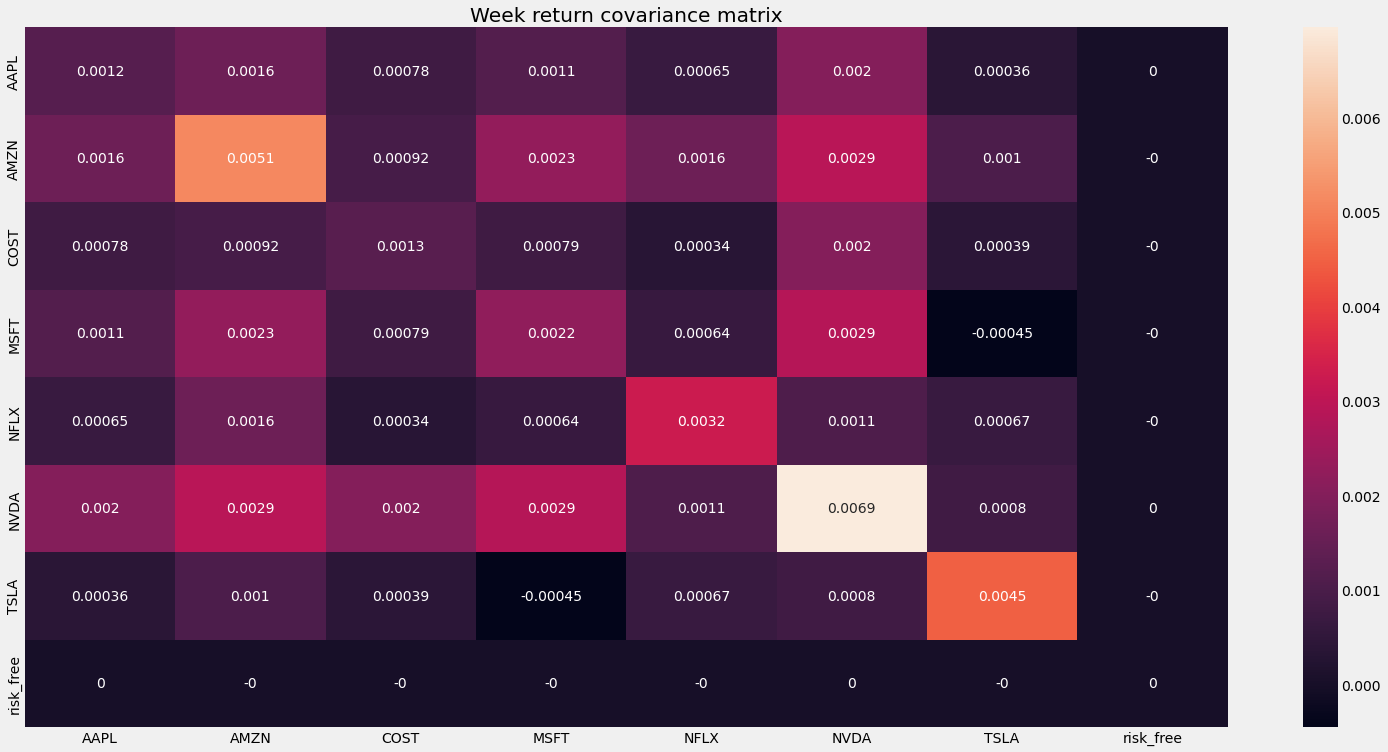

In [10]:
sns.heatmap(np.round(df_r.cov(), 5), annot=True).set(title='Week return covariance matrix')

# Single stock strategy

In [11]:
import cvxpy as cp

In [12]:
def single_stock_curve(data):
    tickers = list(data.columns)
    n = len(tickers)
    ret = ((df - df.shift()) / df.shift()).dropna()
    ret_mean = ret.mean(axis=0).values
    cov = ret.cov().values
    
    risk_data = np.zeros(n)
    ret_data = np.zeros(n)
    for i in range(n):
        ticker = tickers[i]
        risk_data[i] = cov[i, i]
        ret_data[i] = ret_mean[i]

    curve_dict = {
        'risk': risk_data,
        'return': ret_data,
    }
    curve = pd.concat((pd.DataFrame(curve_dict), pd.DataFrame(np.eye(n), columns=tickers)), axis=1)
    
    return curve


In [13]:
single_curve = single_stock_curve(data)
single_curve

,risk,return,AAPL,AMZN,COST,MSFT,NFLX,NVDA,TSLA,risk_free
0,1.221910e-03,-0.001853,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.116740e-03,-0.011432,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.251139e-03,-0.002017,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.229914e-03,-0.001026,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.247717e-03,0.019954,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,6.945167e-03,0.000705,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,4.479627e-03,-0.015250,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,9.217620e-33,0.000567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
def single_stock_portfolio(curve, ticker):
    df = curve[ curve[ticker] == 1]
    return df.iloc[0, 2:], df.iloc[0, :2]

# Markovitz optimal portfolio

In [15]:
def markovitz_portfolio(data, gamma, can_short):
    df = data.copy()
    df_r = ((df - df.shift()) / df.shift()).dropna()
    r = df_r.values.mean(axis=0) # mean returns
    p = df.iloc[-1].values.reshape((-1, 1)) # current prices
    sigma = df_r.cov().values # covariance matrix

    w = cp.Variable(r.shape) # portfolio 
    gamma = gamma # risk parameter
    
    ret = r.T @ w
    risk = cp.quad_form(w, sigma)
    
    if can_short:
        constraints = [cp.norm(w, 1) <= 1]
    else:
        constraints = [cp.sum(w) == 1, w >= 0]
    
    prob = cp.Problem(
        cp.Maximize(gamma * ret - risk),
        constraints
    )
    prob.solve()
    params = {
        'risk': risk.value,
        'return': ret.value,
    }
    return pd.Series(np.round(w.value, 3), index=df.columns), params

In [16]:
def markovitz_curve(data, can_short=False):
    SAMPLES = 1000
    tickers = list(data.columns)
    
    risk_data = np.zeros(SAMPLES)
    ret_data = np.zeros(SAMPLES)
    weights = []
    gamma_vals = np.logspace(-5, 3, num=SAMPLES)
    for i in range(SAMPLES):
        gamma = gamma_vals[i]
        w, params = markovitz_portfolio(data, gamma, can_short)
        risk_data[i] = params['risk']
        ret_data[i] = params['return']
        weights.append(w)
    weights = np.array(weights)
    curve_dict = {
        'risk': risk_data,
        'return': ret_data,
        'gamma': gamma_vals,
    }
    curve_dict.update({tickers[i]: weights[:, i] for i in range(len(tickers))})
    curve = pd.DataFrame(curve_dict)
    
    return curve

In [17]:
no_short = {}
for tau in [0, 0.2, 0.4, 0.6]:
    no_short[f'tau = {tau}'] = markovitz_portfolio(data, tau, can_short=False)[0]
print('Stock proportions: long only portfolio')
no_short = pd.DataFrame(no_short).T
no_short

Stock proportions: long only portfolio


,AAPL,AMZN,COST,MSFT,NFLX,NVDA,TSLA,risk_free
tau = 0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.000
tau = 0.2,-0.0,-0.0,-0.0,-0.0,0.597,-0.0,-0.0,0.403
tau = 0.4,-0.0,-0.0,-0.0,-0.0,1.000,-0.0,-0.0,-0.000
tau = 0.6,0.0,-0.0,-0.0,0.0,1.000,-0.0,-0.0,-0.000


In [18]:
can_short = {}
for tau in [0, 0.2, 0.4, 0.6]:
    can_short[f'tau = {tau}'] = markovitz_portfolio(data, tau, can_short=True)[0]
print('Stock proportion: can short portfolio')
can_short = pd.DataFrame(can_short).T
can_short

Stock proportion: can short portfolio


,AAPL,AMZN,COST,MSFT,NFLX,NVDA,TSLA,risk_free
tau = 0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.0
tau = 0.2,0.0,-0.222,0.0,-0.0,0.559,0.0,-0.219,-0.0
tau = 0.4,-0.0,-0.147,-0.0,-0.0,0.631,-0.0,-0.221,-0.0
tau = 0.6,-0.0,-0.073,-0.0,-0.0,0.704,-0.0,-0.223,-0.0


In [19]:
single_curve = single_stock_curve(df)
mark_curve = markovitz_curve(df)

<AxesSubplot:xlabel='risk', ylabel='return'>

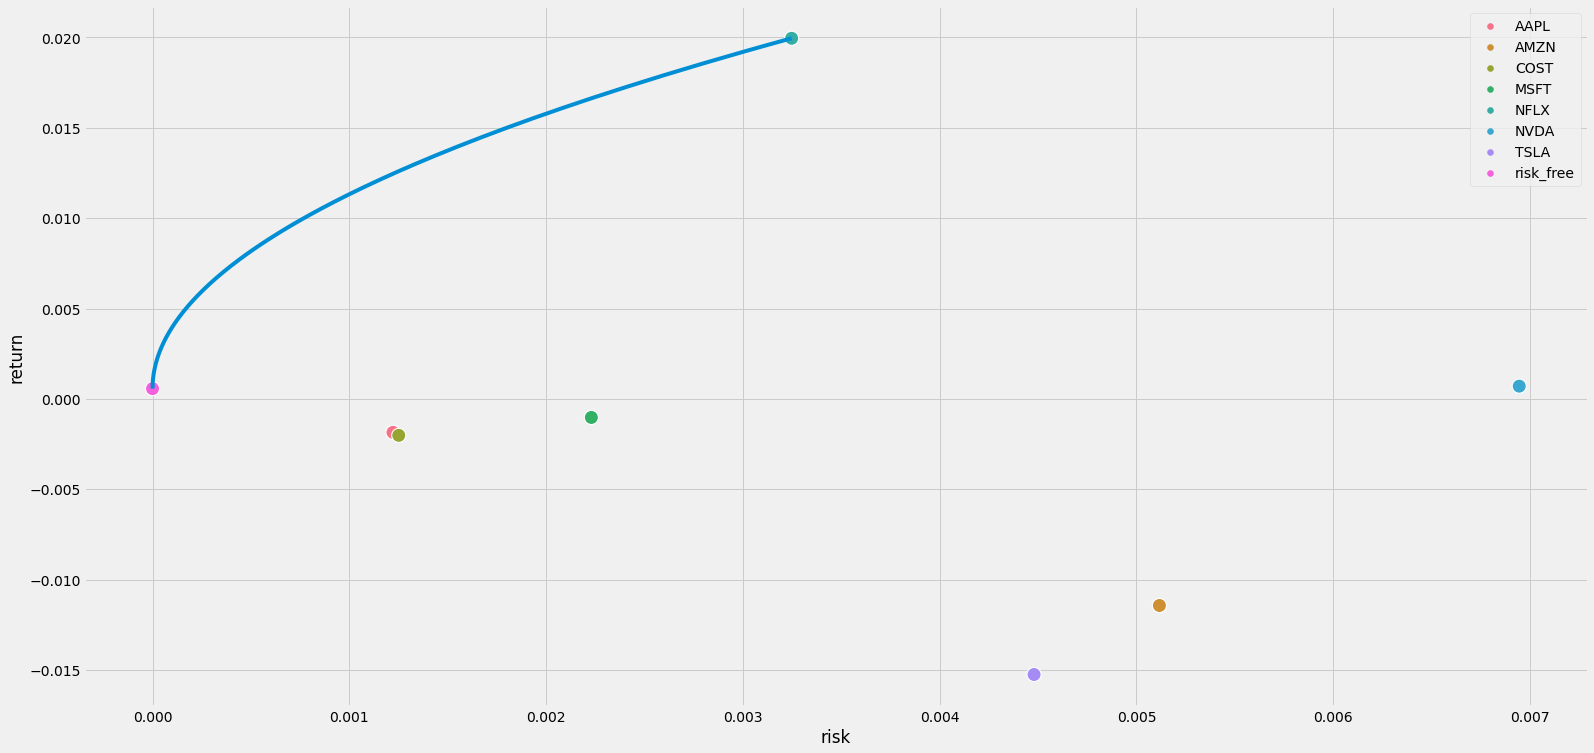

In [20]:
sns.lineplot(data=mark_curve, x='risk', y='return')
sns.scatterplot(data=single_curve, x='risk', y='return', hue=df.columns, s=200 )

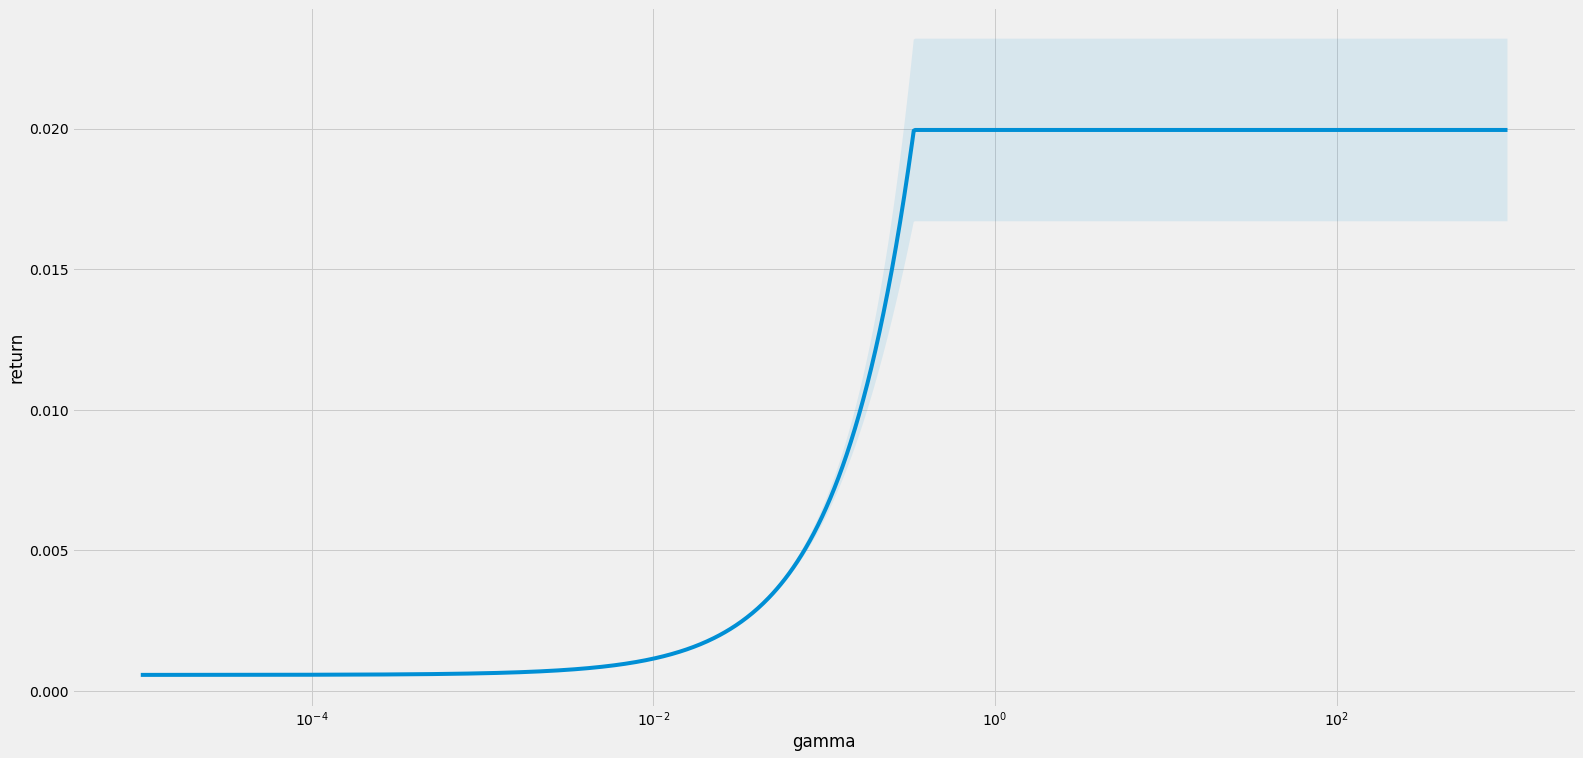

In [21]:
sns.lineplot(data=mark_curve, x='gamma', y='return').set(xscale='log')
plt.fill_between(x=mark_curve['gamma'], y1=mark_curve['return'] - mark_curve['risk'], y2=mark_curve['return'] + mark_curve['risk'], alpha=0.1)

## Custom portfolio

In [22]:
portfolio, stats = markovitz_portfolio(data.iloc[-10:], gamma=1, can_short=False)
portfolio, stats

(AAPL        -0.000
 AMZN        -0.000
 COST        -0.000
 MSFT        -0.000
 NFLX         0.115
 NVDA         0.885
 TSLA         0.000
 risk_free    0.000
 dtype: float64,
 {'risk': 0.004194888113970994, 'return': 0.03971032995444322})

# Test

In [23]:
import yfinance
import datetime

In [24]:
def test_data():
    df = yfinance.download(tickers[:-1], start='2022-12-1')['Close']
    annual_riskfree = 0.03
    dti = np.cumsum((df.index[1:] - df.index[:-1]).days)
    df['risk_free'] = np.r_[1, np.power(1 + annual_riskfree, dti / 365)]
    df.fillna(method='ffill', inplace=True)
    return df

In [25]:
data_now = test_data()
data_now.iloc[-1]

[*********************100%***********************]  7 of 7 completed


AAPL         153.199997
AMZN          99.699997
COST         503.220001
MSFT         272.170013
NFLX         359.959991
NVDA         229.710007
TSLA         209.250000
risk_free      1.006092
Name: 2023-02-14 00:00:00, dtype: float64

<AxesSubplot:xlabel='Date'>

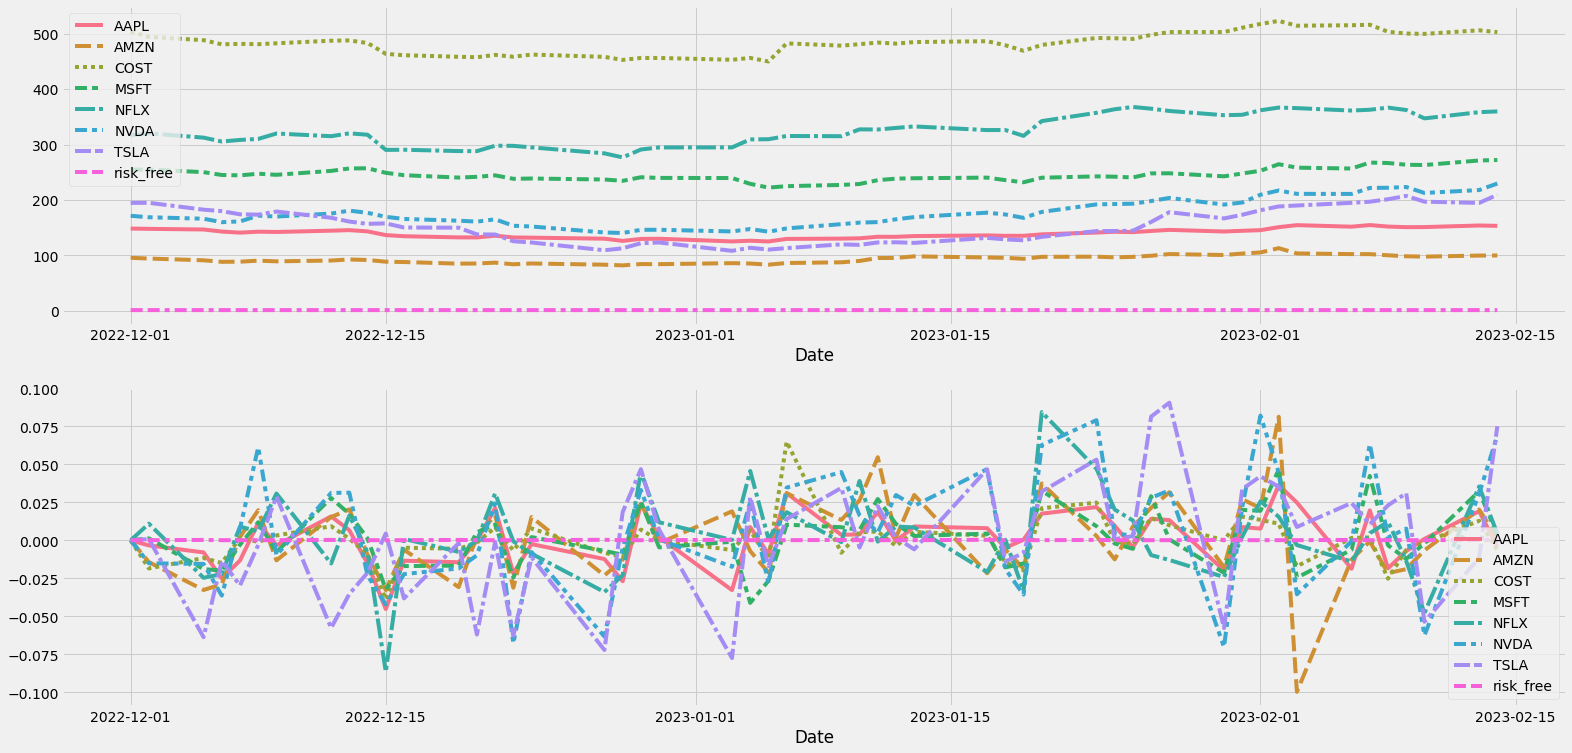

In [26]:
data_now_r = data_now.diff() / data_now.iloc[0]
data_now_r.fillna(0, inplace=True)
fig, ax = plt.subplots(2)
sns.lineplot(data=data_now, ax=ax[0])
sns.lineplot(data=data_now_r, ax=ax[1])

In [27]:
def profit(portfolio, data_now=None, balance=10000):
    if data_now is None:
        data_now = test_data()
    tickers = list(portfolio.index[np.abs(portfolio) > 1e-4])
    print(tickers)
    init_prices = data_now.iloc[0]
    stocks = balance * portfolio / init_prices
    
    stock_stats = (data_now - init_prices) * stocks
    total_stats = pd.DataFrame()
    total_stats['pnl'] = stock_stats.sum(axis=1)
    total_stats['return'] = total_stats['pnl'] / balance
    
    stock_stats = stock_stats[tickers]
    return stocks[tickers], stock_stats, total_stats

In [28]:
def plot_stats(portfolio):
    stocks, stock_stats, total_stats = profit(portfolio, data_now)

    fig, ax = plt.subplots(4, figsize=(24, 24))
    sns.lineplot(data=stock_stats, ax=ax[0]).set(title='Stock pnl')
    sns.lineplot(data=total_stats['pnl'], ax=ax[1]).set(title='Cummulative pnl')
    sns.lineplot(data=total_stats['return'], ax=ax[2]).set(title='Investment return')
    sns.barplot(x=stock_stats.columns, y=stock_stats.iloc[-1], ax=ax[3]).set(title='Total stock pnl')
    return stocks, total_stats.iloc[-1]

## Long only portfolio

In [29]:
portfolio, stats = markovitz_portfolio(data.iloc[-size:], gamma=1, can_short=False)
portfolio, stats

(AAPL        -0.0
 AMZN         0.0
 COST        -0.0
 MSFT        -0.0
 NFLX         1.0
 NVDA        -0.0
 TSLA        -0.0
 risk_free   -0.0
 dtype: float64,
 {'risk': 0.00324771711311861, 'return': 0.019953575428977677})

['NFLX']


(NFLX    31.550717
 dtype: float64,
 pnl       1356.995665
 return       0.135700
 Name: 2023-02-14 00:00:00, dtype: float64)

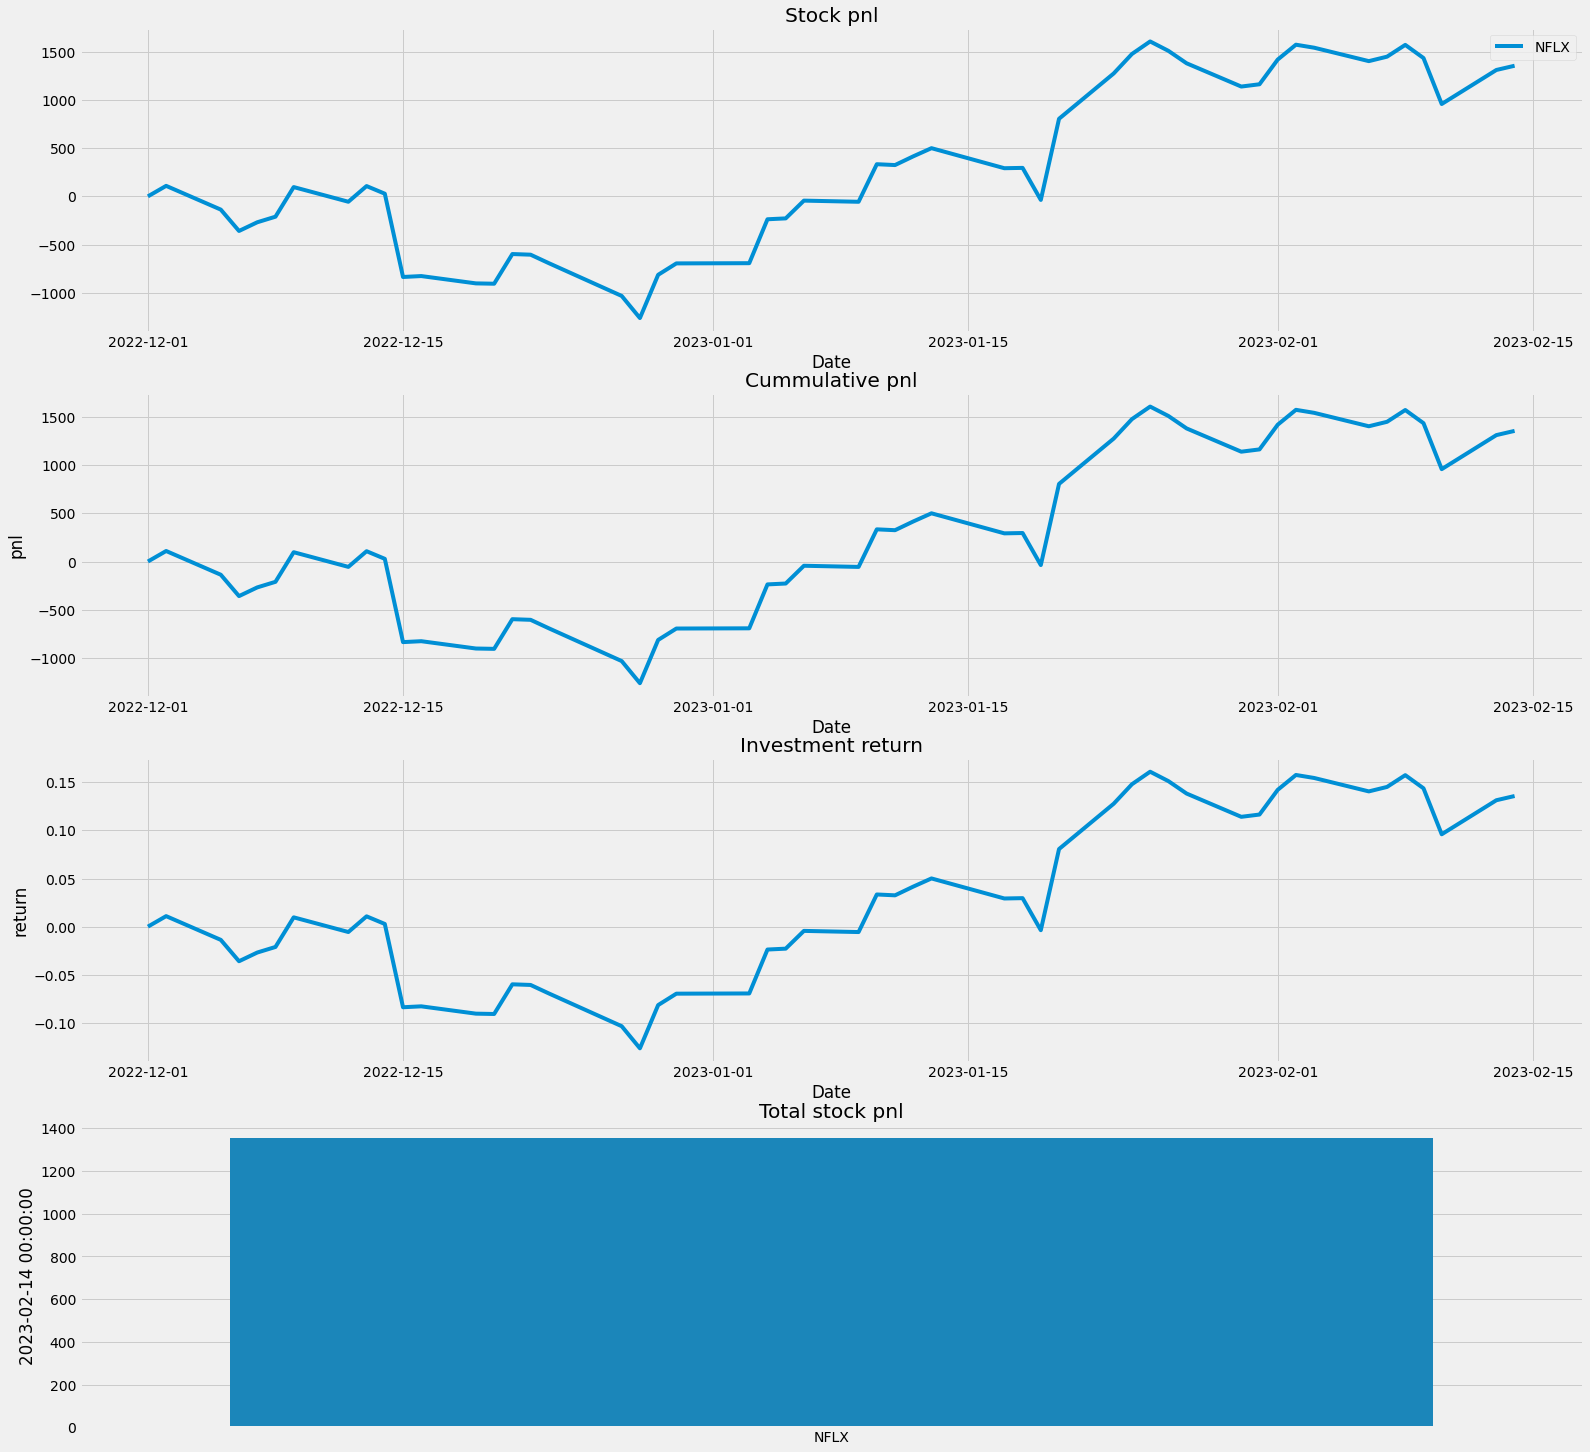

In [30]:
plot_stats(portfolio)

## Can short

In [31]:
portfolio, stats = markovitz_portfolio(data.iloc[-10:], gamma=1, can_short=True)
portfolio, stats

(AAPL        -0.000
 AMZN        -0.000
 COST        -0.000
 MSFT         0.000
 NFLX         0.101
 NVDA         0.829
 TSLA        -0.070
 risk_free   -0.000
 dtype: float64,
 {'risk': 0.003704684786714364, 'return': 0.0392637219370148})

['NFLX', 'NVDA', 'TSLA']


(NFLX     3.186622
 NVDA    48.380506
 TSLA    -3.595275
 dtype: float64,
 pnl       2908.231663
 return       0.290823
 Name: 2023-02-14 00:00:00, dtype: float64)

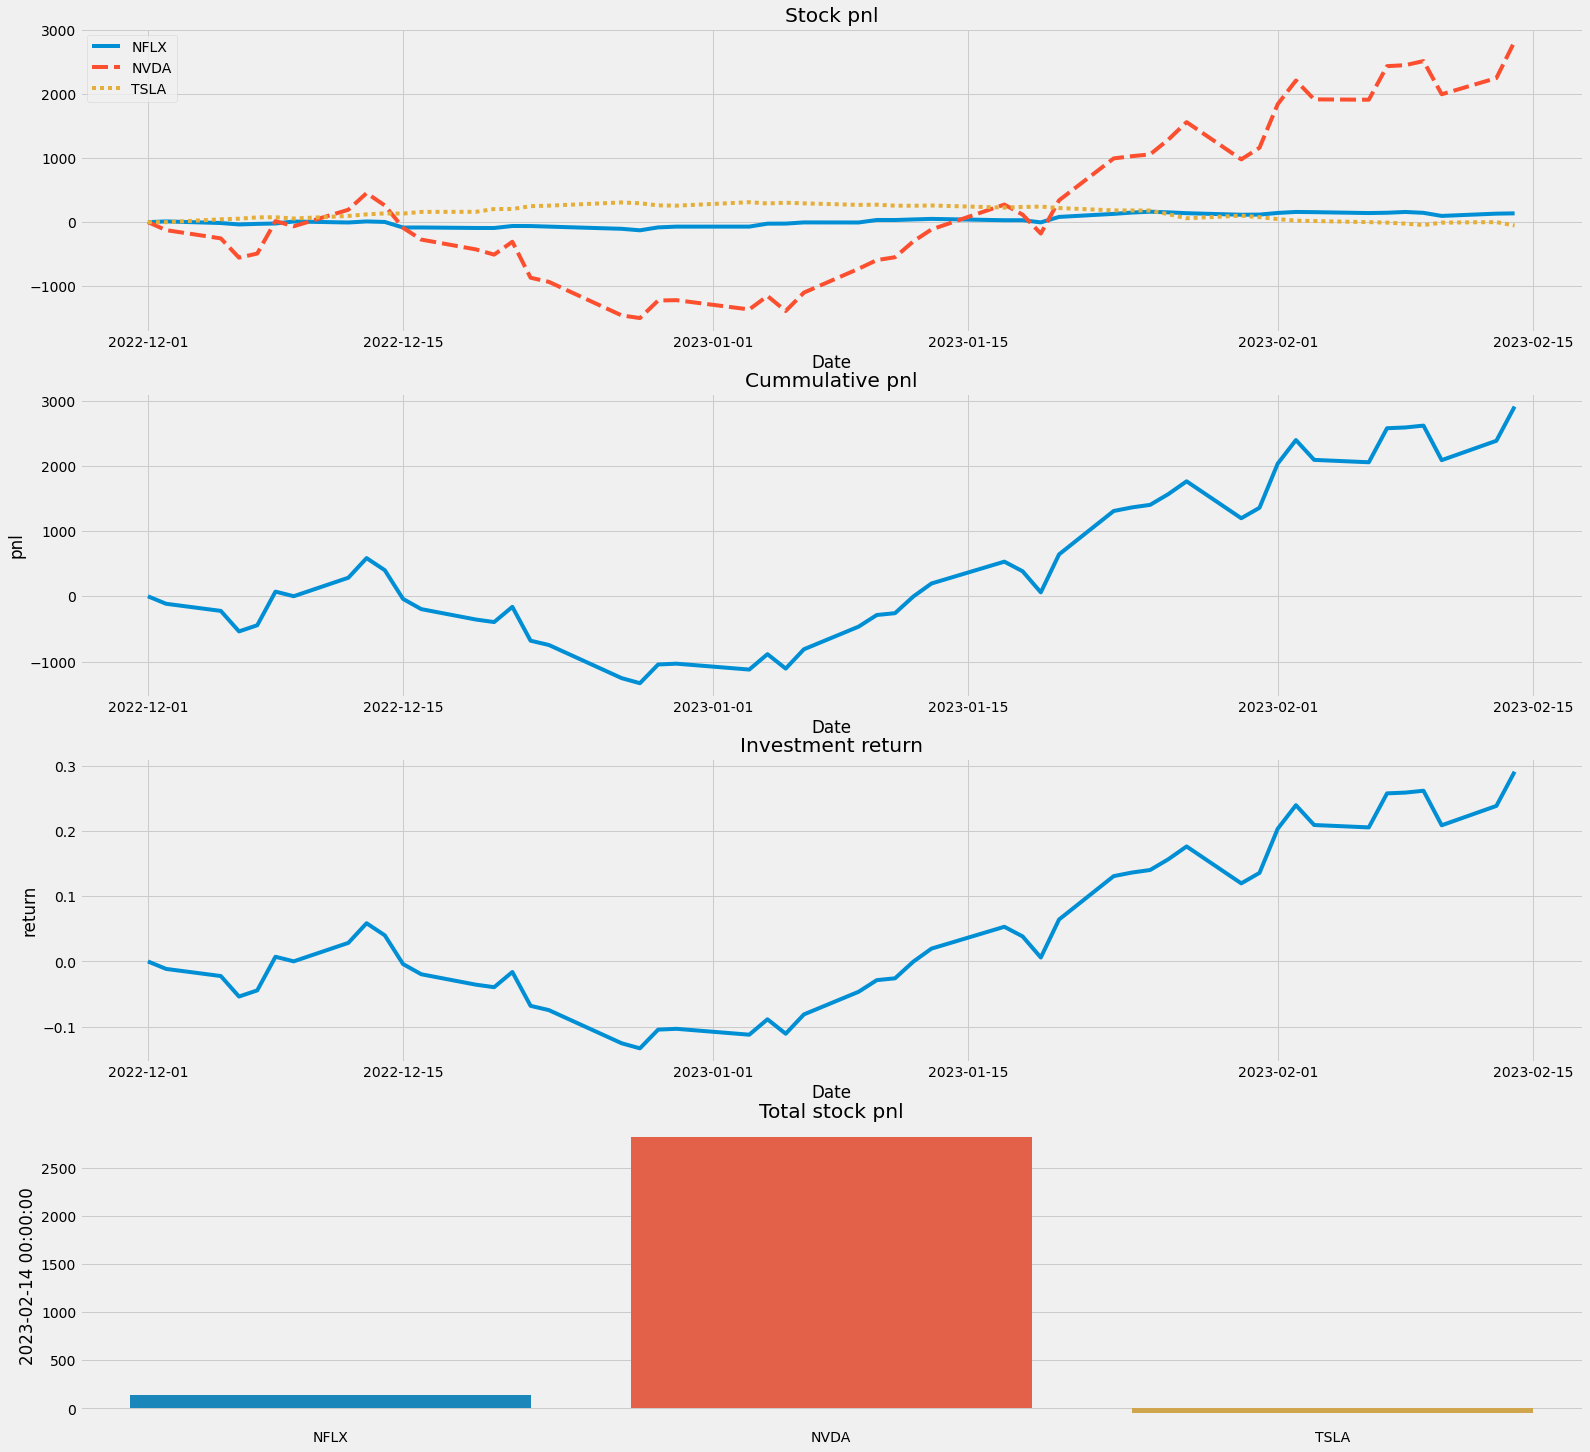

In [32]:
plot_stats(portfolio)